Wine Quality Classification

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import precision_score, recall_score, f1_score

In [2]:
df = pd.read_csv('winequality-red.csv')

In [3]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


Let's suppose I am a very rigid wine drinker and I believe only wines ranked 8 or above are worth calling it good. In that case, the cut-off value will be at 8 therefore transforming my class into a binary column. 1 stands for good and 0 for bad.

In [5]:
df['quality'] = np.where(df['quality'] >= 7, 1, 0)

In [6]:
print('Bad quality wine', round(df['quality'].value_counts()[0]/len(df) * 100,2),'%')
print('Good quality wine', round(df['quality'].value_counts()[1]/len(df) * 100,2),'%')

Bad quality wine 86.43 %
Good quality wine 13.57 %


/Users/andresantospelegrinidasilva/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Class Distributions \n (1: Good quality wine || 1: Bad quality wine)')

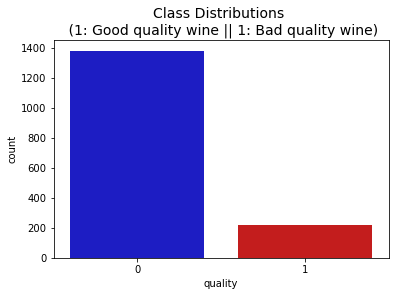

In [7]:
colors = ["#0101DF", "#DF0101"]

sns.countplot('quality', data=df, palette=colors)
plt.title('Class Distributions \n (1: Good quality wine || 1: Bad quality wine)', fontsize=14)

### Preprocessing

As the class is imbalanced, a rebalance is required in order to better evaluate my model. As the dataset can be considered small, I'll go for oversampling using SMOTE, creating synthetic instances for my minor class until it reaches the same number of examples as my major class.

Before oversampling the dataset, it is necessary to split it into train and test as the test dataset must suffer any transformations

In [8]:
X_train, X_test = train_test_split(df, test_size=0.20, random_state=42)
print("Train size: ", X_train.shape)
print("Test size: ", X_test.shape)

Train size:  (1279, 12)
Test size:  (320, 12)


In [9]:
def oversample_dataset(data):
    X = data.drop(columns={'quality'})
    y = data['quality']
    
    sm = SMOTE(random_state=42)
    
    X_sm, y_sm = sm.fit_resample(X, y)
    sm_df = pd.concat([X_sm, y_sm], axis=1)
    
    return sm_df

X_train_sm = oversample_dataset(X_train)

In [10]:
y_train = X_train_sm['quality']
y_test = X_test['quality']
X_train = X_train_sm.drop(columns={'quality'})
X_test = X_test.drop(columns={'quality'})

print("Train size: ", X_train.shape)
print("Test size: ", X_test.shape)

Train size:  (2218, 11)
Test size:  (320, 11)


In [11]:
scaler = StandardScaler()

scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

X_test_scaled = scaler.transform(X_test)

### Models

In [12]:
classifiers = {
    "Decision Tree": DecisionTreeClassifier(max_depth=4, max_features=0.25, min_samples_leaf=5),
    "Support Vector Classifier": SVC(kernel='poly', C=0.025, random_state=42),
    'NaiveBayes': GaussianNB(),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=1),
    "Random Forest": RandomForestClassifier(n_estimators=500, max_features=0.1, min_samples_leaf=5, 
                                            n_jobs=-1, random_state=42,),
}

In [13]:
classifiers = {
    "Decision Tree": DecisionTreeClassifier(),
    "Support Vector Classifier": SVC(),
    'NaiveBayes': GaussianNB(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier(),
}

In [14]:
for key, classifier in classifiers.items():
    classifier.fit(X_train_scaled, y_train)
    training_score = cross_val_score(classifier, X_train_scaled, y_train, cv=5)
    print(classifier.__class__.__name__, "has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

DecisionTreeClassifier has a training score of 90.0 % accuracy score
SVC has a training score of 87.0 % accuracy score
GaussianNB has a training score of 79.0 % accuracy score
KNeighborsClassifier has a training score of 88.0 % accuracy score
RandomForestClassifier has a training score of 93.0 % accuracy score


In [15]:
for key, classifier in classifiers.items():
    classifier.fit(X_train_scaled, y_train)
    testing_score = cross_val_score(classifier, X_test_scaled, y_test, cv=5)
    print(classifier.__class__.__name__, "has a testing score of", round(testing_score.mean(), 2) * 100, "% accuracy score")

DecisionTreeClassifier has a testing score of 83.0 % accuracy score
SVC has a testing score of 86.0 % accuracy score
GaussianNB has a testing score of 82.0 % accuracy score
KNeighborsClassifier has a testing score of 85.0 % accuracy score
RandomForestClassifier has a testing score of 86.0 % accuracy score


In [16]:
for key, classifier in classifiers.items():
    classifier.fit(X_train_scaled, y_train)
    y_test_pred = classifier.predict(X_test_scaled)
    print(classifier.__class__.__name__, "has a training score of", round(f1_score(y_test, y_test_pred), 2), "f1 score")

DecisionTreeClassifier has a training score of 0.64 f1 score
SVC has a training score of 0.64 f1 score
GaussianNB has a training score of 0.48 f1 score
KNeighborsClassifier has a training score of 0.55 f1 score
RandomForestClassifier has a training score of 0.73 f1 score


In [17]:
for key, classifier in classifiers.items():
    classifier.fit(X_train_scaled, y_train)
    y_test_pred = classifier.predict(X_test_scaled)
    print(classifier.__class__.__name__, "has a training score of", round(precision_score(y_test, y_test_pred), 2), "precision score")

DecisionTreeClassifier has a training score of 0.54 precision score
SVC has a training score of 0.51 precision score
GaussianNB has a training score of 0.34 precision score
KNeighborsClassifier has a training score of 0.41 precision score
RandomForestClassifier has a training score of 0.67 precision score


In [18]:
for key, classifier in classifiers.items():
    classifier.fit(X_train_scaled, y_train)
    y_test_pred = classifier.predict(X_test_scaled)
    print(classifier.__class__.__name__, "has a training score of", round(recall_score(y_test, y_test_pred), 2), "recall score")

DecisionTreeClassifier has a training score of 0.79 recall score
SVC has a training score of 0.87 recall score
GaussianNB has a training score of 0.81 recall score
KNeighborsClassifier has a training score of 0.83 recall score
RandomForestClassifier has a training score of 0.81 recall score
